# SVP100 - Hitting The Wall

> Data analysis on a running race

- toc:true
- sticky_rank: 2
- author: Stephen Lemasney

In August of 2017 I ran the SVP100. This is a 100KM trail running race starting in Newmarket (Suffolk, UK) and ending in Manning Tree (Essex, UK). In regular distance marathons, its widely believed runners "hit the wall" at around 30KM mark (or 70% through the race). In this notebook, I want to see if the same holds true over a 100KM distance.

From a high level, the code below performs the following:

* Scrape results data from the race website (using Beautiful Soup)
* Render scraped data into a DataFrame (using Pandas)
* Format (or wrangle) the data into formats we can work with
* Present results in time series graph (using Seaborn)

## 1. Import packages and set configurations

First, let's import some packages. We'll use BeautifulSoup for web scraping, pandas for data analysis, and then seaborn for plotting. 

In [1]:
# Import the packages we'll use for our analysis
import datetime
import time
import requests

from bs4 import BeautifulSoup
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

Then we set the plotting configuration. I really like the "fivethirtyeight" stylesheet which generates plots in the style used by fivethirtyeight.com.

In [2]:
# Use line magic function to enable matplotlib to work interactively with iPython

%matplotlib inline
%pylab inline

# Set style to fivethirtyeight to create clean and clear looking graphs

plt.style.use('fivethirtyeight')

# Define a dictionary containing default plotting configurations

params = {'legend.fontsize': 'small',
          'figure.figsize': (12, 4.5),
         'axes.labelsize': 'small',
         'axes.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}

pylab.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


Next define some constants that we'll use in the notebook. First we define a URL which has a table which contains race result data. Then we have some details about the race distance.

In [3]:
# URL details for requests
BASE_URL = "http://www.svp100.co.uk/results-"
YEAR = 2017

# Constants of race details
DISTANCE_BETWEEN_CPS = [19.312, 17.702, 16.094, 17.702, 9.657, 13.679, 7.242]
CPS_IN_KM = cp_miles = [(i * 1.60934) for i in [12, 23, 33, 44, 50, 58.5, 63]]

## 2. Generate unformatted table of race data

In the function below, we request data from the race website and return a DataFrame. For the most part, the DataFrame is unformatted.

In [4]:
#collapse-hide

def df_builder(base_url=BASE_URL, year=YEAR):
    
    """
    This function returns a pandas DataFrame which contain data scraped from the race website.
    The data is unformatted.
    
    Attributes:
    -----------
    base_url (str): the url which contains race data in HTML
    year (int): the year for we would like data
    """
    
    # Scrape the data from the race website
    url = base_url + str(year)
    r = requests.get(url).text
    soup = BeautifulSoup(r, 'lxml')
    
    # Find tables from the html
    rows = soup.find_all('tr')[1:]
    
    # Collect and format column names for the dataframe
    column_html = soup.find_all('th')[:]    
    columns = [i.contents[0].lower().replace("/","").replace(" ", "_") for i in column_html if i.contents[0]]

    # Build a dataframe
    data = []
    for line in rows:
        row = line.find_all('td')
        row_list = []
        for counter, value in enumerate(row):
            row_list.append(row[counter].string)
        data.append(row_list)
    
    # Remove columns we don't need
    df = pd.DataFrame(data, columns=columns).drop(columns = ["name", "club", "mf", "bib", "total_time"]).set_index("position")
            
    return df


Generate a DataFrame of race results for the year 2017.

In [5]:
unformatted_df = df_builder(BASE_URL, YEAR)
unformatted_df.head(2)

,start,cp1,cp2,cp3,cp4,cp5,cp6,finish
position,,,,,,,,
1,08:30:00,09:58:30,11:26:51,12:58:00,14:34:00,15:41:00,17:04:49,17:54:10
2,08:30:00,09:56:03,11:22:10,13:20:00,15:14:00,16:31:00,18:13:51,19:09:10


Scanning the data, we notice a few things...

1. The "time" related columns are strings representing a time of day. We'll need to convert these to datetimes so we can calculate the time (in seconds) between each checkpoint.

2. There are some None values which will need to be removed. 

## 3. Calculate the time for each runner between checkpoints

In the function below, we calculate the time (in seconds) it took each runner to run between checkpoints. Before we start, however, we want to remove any rows which have None values.

In [6]:
# Remove any None rows
unformatted_df = unformatted_df.dropna().copy()

Now onto our function...

In [7]:
#collapse-hide

def calculate_time_to_checkpoints(df):
    
    """
    This function returns a pandas DataFrame which contains time in seconds it took each
    runner to reach a checkpoint
    
    Attributes:
    -----------
    df (DataFrame): a dataframe of race results
    """
    
    # List out a set of columns which we'll need to convert into datimes 
    dt_cols = ["start", "cp1", "cp2", "cp3", "cp4", "cp5", "cp6", "finish"]
    
    # Convert these columns to datetimes
    for col in dt_cols:
    
        df[col] = df[col].apply(lambda x: pd.to_datetime("2017-08-08 " + str(x)))
    
    # Then calculate the time in seconds between each checkpoint
    for start, end in zip(dt_cols, dt_cols[1:]):
        
        df[f"time_to_{end}"] = (df[end] - df[start]).apply(lambda x: x.seconds)
    
    # Finally lets drop the old 'time of day' columns
    df = df.drop(columns=dt_cols).rename(columns={"time_to_finish": "time_to_cp7"}).copy()

    return df

In [8]:
df_time_to_cp = calculate_time_to_checkpoints(unformatted_df)
df_time_to_cp.head(3)

,time_to_cp1,time_to_cp2,time_to_cp3,time_to_cp4,time_to_cp5,time_to_cp6,time_to_cp7
position,,,,,,,
1,5310,5301,5469,5760,4020,5029,2961
2,5163,5167,7070,6840,4620,6171,3319
3,6284,6382,6534,6720,4440,5869,3426


## 4. Calculate the minutes per KM for each runner between checkpoints

Next we calculate the minutes per km it took each runner to move between checkpoints.

In [9]:
#collapse-hide

def calc_mins_per_km(df):
    
    """
    This function returns a pandas DataFrame which contains min per km
    it took each runner to move between checkpoints
    
    Attributes:
    -----------
    df (DataFrame): a dataframe of race results
    """

    df = df.copy()
    
    for cp_time, distance in zip(df.columns, DISTANCE_BETWEEN_CPS):

        df[f"min_per_km_{cp_time[-3:]}"] = df[cp_time].apply(lambda x: (x / distance) / 60)

        df.drop(columns=[cp_time], inplace=True)
        
    df.columns = CPS_IN_KM
        
    return df

The DataFrame below shows how long it took to move between each checkpoint. In this DataFrame we've also replaced the checkpoint numbers with their distances in kilometers.

In [10]:
df_min_per_km = calc_mins_per_km(df_time_to_cp)
df_min_per_km.head(3)

,19.31208,37.01482,53.10822,70.81096,80.46700,94.14639,101.38842
position,,,,,,,
1,4.582643,4.990961,5.663601,5.423116,6.937972,6.127397,6.814416
2,4.455779,4.864799,7.321569,6.439950,7.973491,7.518824,7.638314
3,5.423226,6.008737,6.766497,6.326969,7.662835,7.150864,7.884562


## 5. Calculate averages for three groups

Then we calculate averages for three groups:

1. All runners
2. The Top 10 only
3. Me only 

In [11]:
all_runners = pd.DataFrame(df_min_per_km.mean(), columns=["all_runners"])
top_10_runners = pd.DataFrame(df_min_per_km.head(10).mean(), columns=["top_10"])
me = pd.DataFrame(df_min_per_km.filter(items=['7'], axis=0).mean(), columns=["me"])

In [12]:
plots = all_runners.join(top_10_runners, lsuffix = "_all", rsuffix  = "_t10").join(me)
plots.index.rename("kilometer", inplace=True)
plots

,all_runners,top_10,me
kilometer,,,
19.31208,6.284585,5.366094,5.670050
37.01482,7.424970,6.037736,6.679095
53.10822,7.954279,6.728595,7.162089
70.81096,8.467717,6.880578,7.287312
80.46700,11.937517,8.594802,9.009009
94.14639,9.395034,7.693545,7.772254
101.38842,9.952413,7.907806,7.764890


## 6. Plot results on line chart

Looking at the results below, we can see that all three groups move in a similar pattern, slowing down substantially at 80KM, before picking up the pace for the final 20KM.

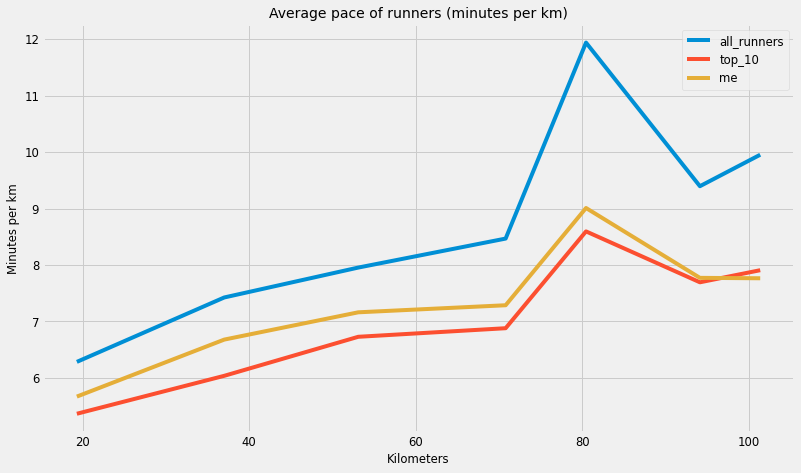

In [13]:
plots.plot(y = ["all_runners","top_10","me"], figsize=(12,7))
plt.title('Average pace of runners (minutes per km)')
plt.ylabel('Minutes per km', fontsize="small")
plt.xlabel('Kilometers')
plt.show()